In [75]:
import numpy as np
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import sklearn.preprocessing as prep
import tensorflow as tf

from LstmVAE import LSTM_Var_Autoencoder
from LstmVAE import preprocess

name = '/home/mabbasloo/Documents/carData4/data/lbo/'
name1 = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/data/'

In [76]:
filename = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/list'

with open(filename) as f:
    data = f.readlines() 
data = [x.strip() for x in data]     
print (len(data), np.int(len(data)/60))
print (data[0])
print (data[len(data)-1])

12360 206
f001_S2000001_1.mat
f299_S2000001_60.mat


In [82]:
DATA = []
d = 10
hm = 20
db = h5py.File(name + data[0], 'r')
ds = db['Phi']
ds = np.asarray(ds).astype(np.float32).T
ds = ds[:, 0:d]
ds[np.isnan(ds)] = 0.0
ds[np.isinf(ds)] = 0.0
for i in range(hm*60):
    #db = h5py.File(name + data[i], 'r')
    #ds = db['Phi']
    #ds = np.asarray(ds).astype(np.float32).T
    #ds = ds[:, 500-d:]
    #print (ds.shape)
    db1 = h5py.File(name1 + data[i], 'r')
    ds1 = db1['shape_xyz']
    ds1 = np.asarray(ds1).astype(np.float32)
    ds1[np.isnan(ds1)] = 0.0
    ds1[np.isinf(ds1)] = 0.0
    ds1[0] = ds1[0]/np.linalg.norm(ds1[0])
    ds1[1] = ds1[1]/np.linalg.norm(ds1[1])
    ds1[2] = ds1[2]/np.linalg.norm(ds1[2])    
    DATA.append(np.dot(ds1, ds))
print (len(DATA), DATA[0].shape)

def standard_scale(X_train):
    for i in range(len(X_train)):
        X_train[i] = X_train[i]/np.linalg.norm(X_train[i], 'fro')
    return X_train

DATA = standard_scale(DATA)

1200 (3, 10)


Text(0.5, 0, 'z')

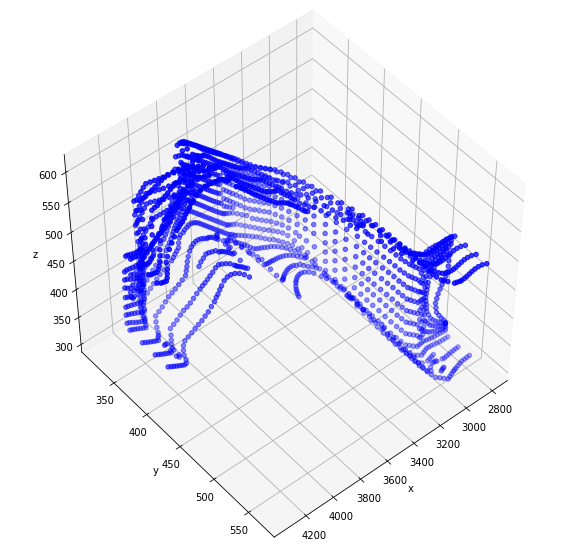

In [83]:
db1 = h5py.File(name1 + data[0], 'r')
ds1 = db1['shape_xyz']
ds1 = np.asarray(ds1).astype(np.float32)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ds1[0], ds1[1], ds1[2], c='b', marker='o')
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

(3, 1714)


Text(0.5, 0, 'z')

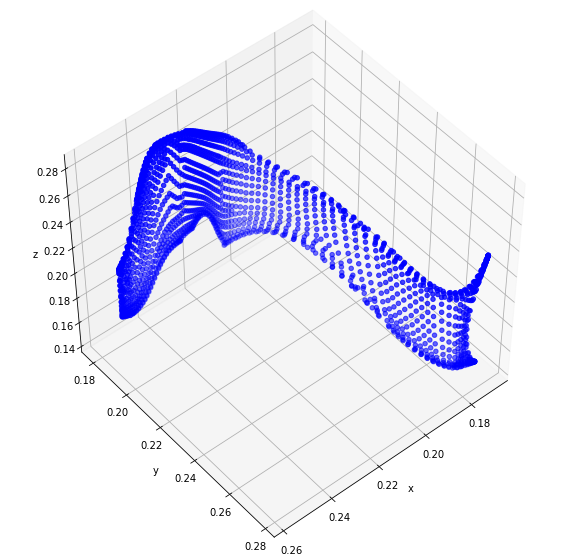

In [84]:
xyz = np.dot(DATA[0], np.linalg.pinv(ds))
print (xyz.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['o', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], c=c[0], marker=m[0])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

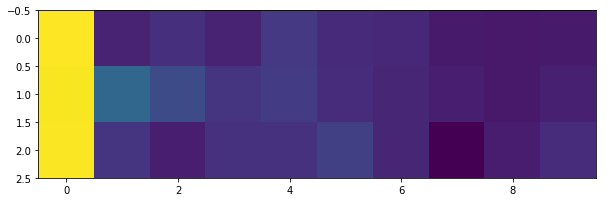

In [85]:
plt.figure(figsize=(10, 10)); 
plt.imshow(DATA[0])

In [86]:
vae = LSTM_Var_Autoencoder(intermediate_dim = 10, z_dim = 3, n_dim=d, stateful = False) #default stateful = False

vae.fit(DATA[0:15*60], learning_rate=0.001, batch_size = 10, num_epochs = 100, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01, grad_clip_norm=10, optimizer_params=None, verbose = True)



Training...


Epoch   1    Loss 0.03066
Epoch   11   Loss 0.00053
Epoch   21   Loss 0.00001
Epoch   31   Loss 0.00000
Epoch   41   Loss 0.00000
Epoch   51   Loss 0.00000
Epoch   61   Loss 0.00000
Epoch   71   Loss 0.00000
Epoch   81   Loss 0.00000
Epoch   91   Loss 0.00000


Training time 1.26 minutes


In [92]:
x_reconstructed, recons_error = vae.reconstruct(DATA[15*60:20*60], get_error = True) #returns squared error

x_reduced = vae.reduce(DATA) #latent space representation

Text(0.5, 0, 'latent 3')

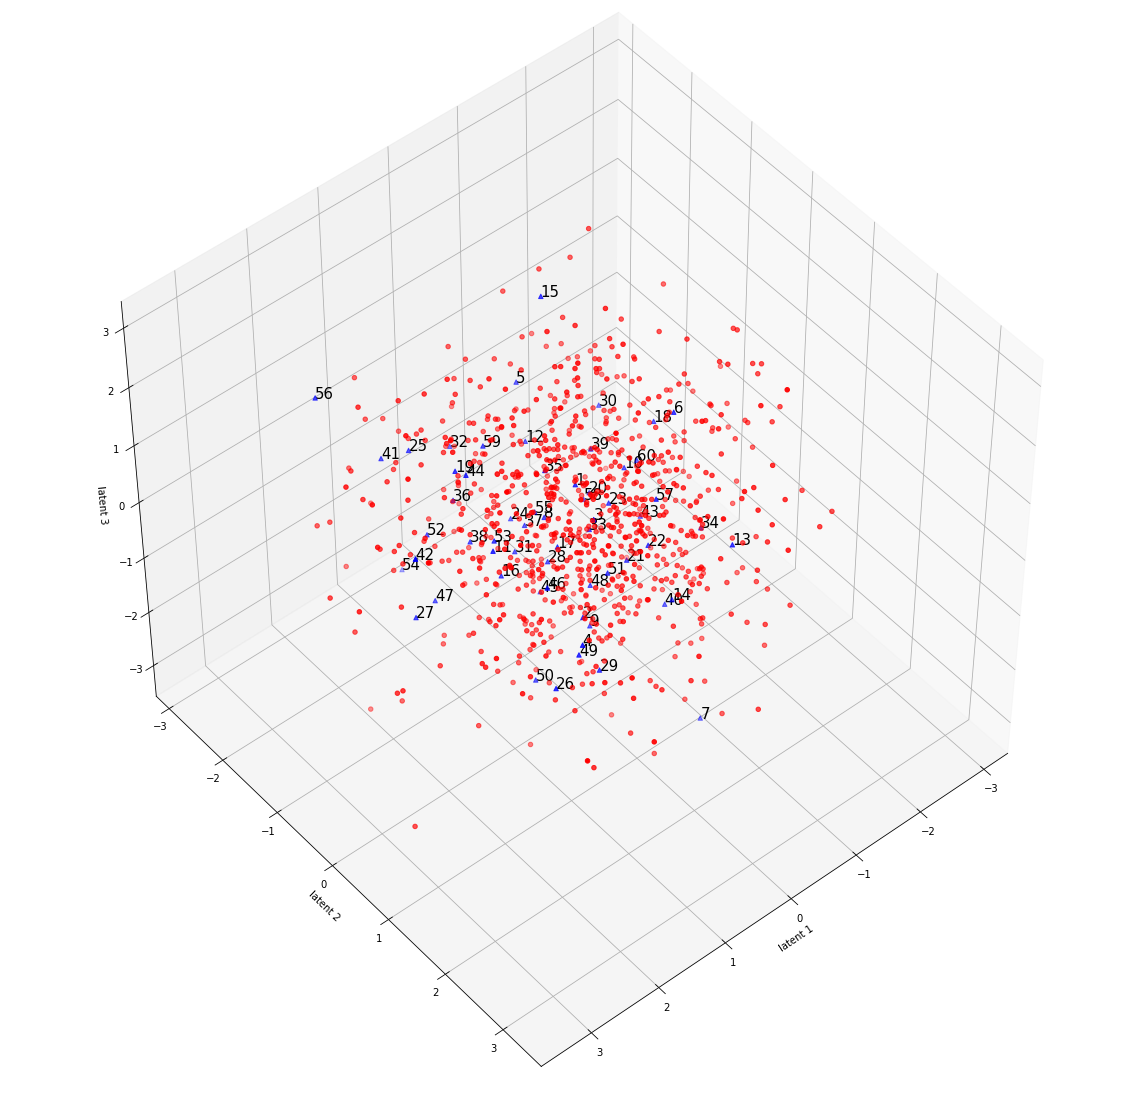

In [93]:
fig = plt.figure(figsize=(20, 20))
c = ['r', 'b']
m = ['o', '^']
label = []
for i in range(1, 60+1):
    label.append(np.str(i))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_reduced[0:15*60, 0], x_reduced[0:15*60, 1], x_reduced[0:15*60, 2], c=c[0], marker=m[0])
ax.scatter(x_reduced[15*60:16*60, 0], x_reduced[15*60:16*60, 1], x_reduced[15*60:16*60, 2], c=c[1], marker=m[1])
ii = 0
for i in range(15*60, 16*60):
    ax.text(x_reduced[i, 0], x_reduced[i, 1], x_reduced[i, 2], label[ii], size=15, zorder=1, color='k') 
    ii += 1
ax.view_init(50, 50)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')

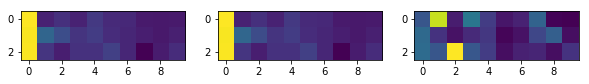

In [94]:
plt.figure(figsize=(10, 30)); 
plt.subplot(1,3,1); plt.imshow(x_reconstructed[0])
plt.subplot(1,3,2); plt.imshow(DATA[15*60])
plt.subplot(1,3,3); plt.imshow(np.abs(x_reconstructed[0] - DATA[10*60]))

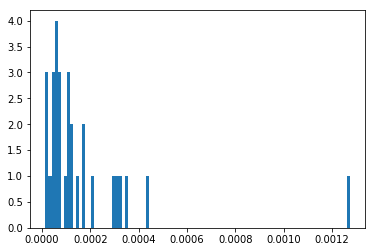

In [96]:
_,_,_ = plt.hist(np.abs(x_reconstructed[0] - DATA[15*60]).reshape((3*d)), bins=100)

(3, 1714)


Text(0.5, 0, 'z')

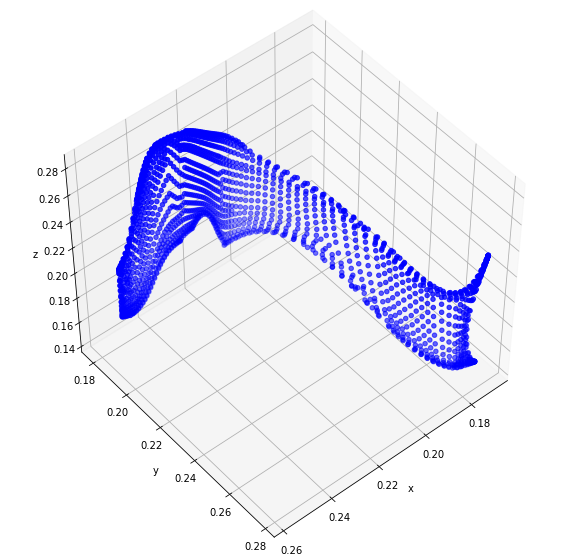

In [97]:
xyz = np.dot(DATA[15*60], np.linalg.pinv(ds))
print (xyz.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['o', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], c=c[0], marker=m[0])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

(3, 1714)


Text(0.5, 0, 'z')

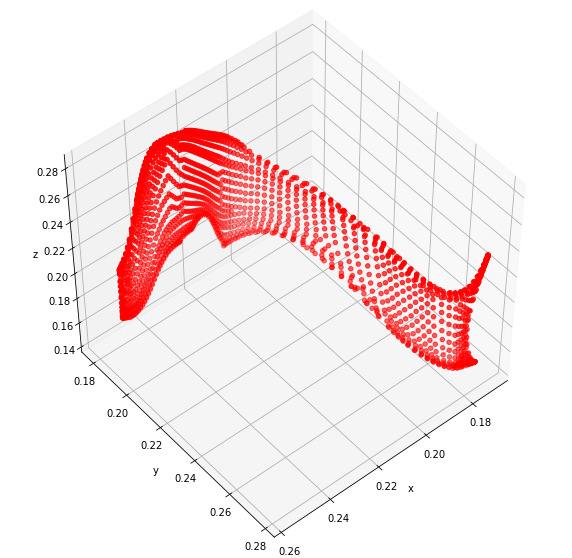

In [98]:
xyz_reconstructed = np.dot(x_reconstructed[0], np.linalg.pinv(ds))
print (xyz_reconstructed.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['^', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_reconstructed[0], xyz_reconstructed[1], xyz_reconstructed[2], c=c[1], marker=m[1])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [109]:
print (x_reduced.shape)
DATA2 = []
for i in range(20):
    d = x_reduced[i*60:(i+1)*60].T
    d[0] = d[0]/np.linalg.norm(d[0])
    d[1] = d[1]/np.linalg.norm(d[1])
    d[2] = d[2]/np.linalg.norm(d[2])

    DATA2.append(d)
print (len(DATA2), DATA2[0].shape)  
dd = 60

(1200, 3)
20 (3, 60)


In [118]:
vae2 = LSTM_Var_Autoencoder(intermediate_dim = 5, z_dim = 3, n_dim=dd, stateful = True) #default stateful = False

vae2.fit(DATA2[0:19], learning_rate=0.002, batch_size = 10, num_epochs = 400, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01, grad_clip_norm=10, optimizer_params=None, verbose = True)



Training...


Epoch   1    Loss 0.03327
Epoch   11   Loss 0.01776
Epoch   21   Loss 0.01714
Epoch   31   Loss 0.01672
Epoch   41   Loss 0.01655
Epoch   51   Loss 0.01649
Epoch   61   Loss 0.01643
Epoch   71   Loss 0.01640
Epoch   81   Loss 0.01631
Epoch   91   Loss 0.01632
Epoch  101   Loss 0.01626
Epoch  111   Loss 0.01628
Epoch  121   Loss 0.01623
Epoch  131   Loss 0.01617
Epoch  141   Loss 0.01607
Epoch  151   Loss 0.01610
Epoch  161   Loss 0.01603
Epoch  171   Loss 0.01608
Epoch  181   Loss 0.01601
Epoch  191   Loss 0.01601
Epoch  201   Loss 0.01596
Epoch  211   Loss 0.01599
Epoch  221   Loss 0.01597
Epoch  231   Loss 0.01595
Epoch  241   Loss 0.01592
Epoch  251   Loss 0.01590
Epoch  261   Loss 0.01595
Epoch  271   Loss 0.01592
Epoch  281   Loss 0.01598
Epoch  291   Loss 0.01591
Epoch  301   Loss 0.01595
Epoch  311   Loss 0.01591
Epoch  321   Loss 0.01591
Epoch  331   Loss 0.01593
Epoch  341   Loss 0.01594
Epoch  351   Loss 0.01594
Epoch  361   Loss 0.01596
Epoch  371   Loss 0.01

In [119]:
x_reconstructed2, recons_error2 = vae2.reconstruct(DATA2[19:20], get_error = True) #returns squared error

x_reduced2 = vae2.reduce(DATA2) #latent space representation

Text(0.5, 0, 'latent 3')

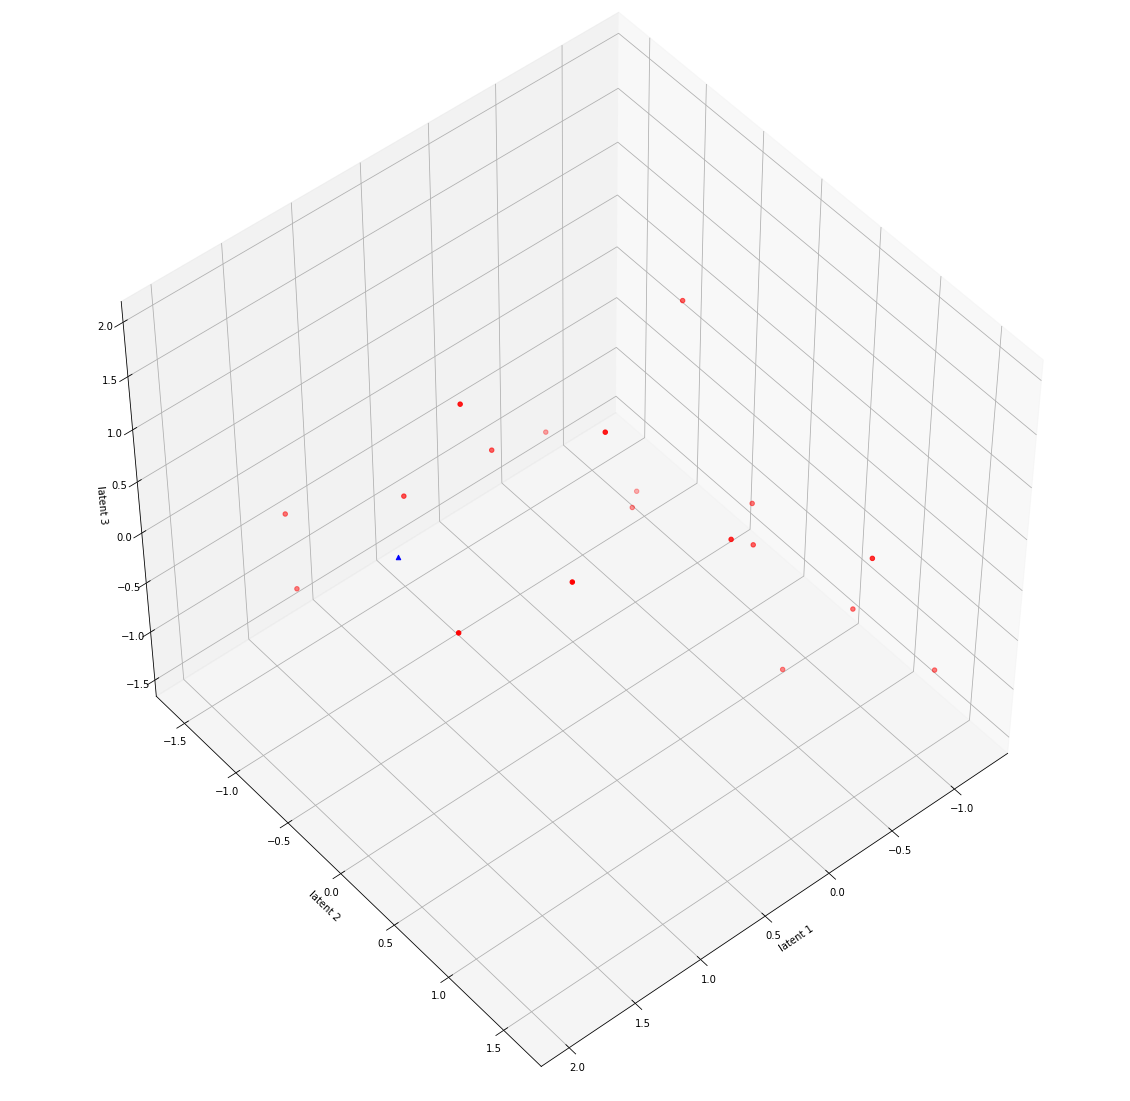

In [120]:
fig = plt.figure(figsize=(20, 20))
c = ['r', 'b']
m = ['o', '^']

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_reduced2[0:19, 0], x_reduced2[0:19, 1], x_reduced2[0:19, 2], c=c[0], marker=m[0])
ax.scatter(x_reduced2[19:20, 0], x_reduced2[19:20, 1], x_reduced2[19:20, 2], c=c[1], marker=m[1])

ax.view_init(50, 50)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')

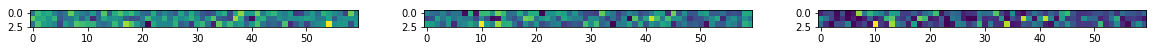

In [123]:
plt.figure(figsize=(20, 60)); 
plt.subplot(1,3,1); plt.imshow(x_reconstructed2[0])
plt.subplot(1,3,2); plt.imshow(DATA2[19])
plt.subplot(1,3,3); plt.imshow(np.abs(x_reconstructed2[0] - DATA2[19]))

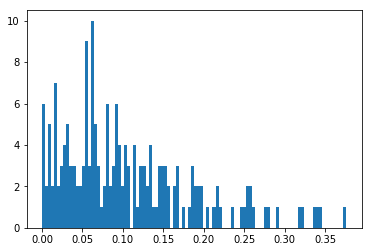

In [122]:
_,_,_ = plt.hist(np.abs(x_reconstructed2[0] - DATA2[19]).reshape((3*dd)), bins=100)